## Import libraries

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Prepare and explore data

In [2]:
import os

input_dir = 'Development/Screenshots'
target_dir = 'Development/ScreenshotMasks'
img_size = (480, 640)
batch_size = 1

input_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith('.png')
    ]
)
target_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith('.txt')
    ]
)

if (len(input_paths) != len(target_paths)):
    raise Exception('dataset error')

input_paths = input_paths[:10]
target_paths = target_paths[:10]

num_samples = len(input_paths)
print('Number of samples:', num_samples)

classes = {
    0: 'Background',
    1: 'Field',
    2: 'Lines',
    3: 'Ball',
    4: 'Robots',
    5 : 'Goals',
}

num_classes = len(classes)
print('Number of classes:', num_classes)

print('Paths: ')
for input_path, target_path in zip(input_paths[:5], target_paths[:5]):
    print(input_path, '|', target_path)


# Shuffle the data
indexes = np.arange(len(input_paths), dtype = int)
np.random.shuffle(indexes)

input_paths = [input_paths[i] for i in indexes]
target_paths = [target_paths[i] for i in indexes]

print('Paths after shuffle: ')

for input_path, target_path in zip(input_paths[:5], target_paths[:5]):
    print(input_path, '|', target_path)

Number of samples: 10
Number of classes: 6
Paths: 
Development/Screenshots/ScreenShot00000.png | Development/ScreenshotMasks/mask000.txt
Development/Screenshots/ScreenShot00001.png | Development/ScreenshotMasks/mask001.txt
Development/Screenshots/ScreenShot00002.png | Development/ScreenshotMasks/mask002.txt
Development/Screenshots/ScreenShot00003.png | Development/ScreenshotMasks/mask003.txt
Development/Screenshots/ScreenShot00004.png | Development/ScreenshotMasks/mask004.txt
Paths after shuffle: 
Development/Screenshots/ScreenShot00000.png | Development/ScreenshotMasks/mask000.txt
Development/Screenshots/ScreenShot00001.png | Development/ScreenshotMasks/mask001.txt
Development/Screenshots/ScreenShot00008.png | Development/ScreenshotMasks/mask008.txt
Development/Screenshots/ScreenShot00006.png | Development/ScreenshotMasks/mask006.txt
Development/Screenshots/ScreenShot00005.png | Development/ScreenshotMasks/mask005.txt


## Display the data

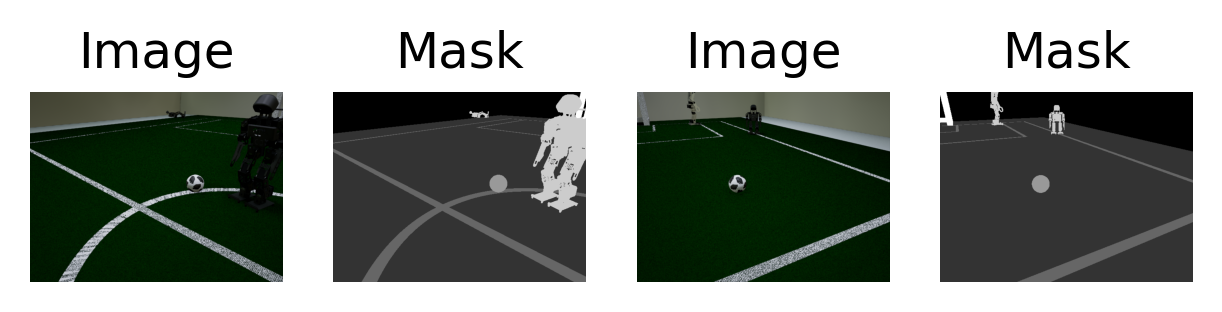

In [3]:
plt.figure(figsize=(5, 10), dpi=300)
for i in range(2):
    img = tf.keras.preprocessing.image.load_img(input_paths[i], target_size=(*img_size, 3))
    plt.subplot(1, 4, i*2+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Image')
    plt.subplot(1, 4, i*2+2)
    mask = np.loadtxt(target_paths[i])
    plt.imshow(mask/mask.max(), cmap='gray')
    plt.axis('off')
    plt.title('Mask')
plt.show()

## Create helper to iterate over the data

In [4]:
class RoboCup(tf.keras.utils.Sequence):
    '''Helper to iterate over the data (as Numpy arrays).'''

    def __init__(self, batch_size, img_size, input_paths, target_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_paths = input_paths
        self.target_paths = target_paths

    def __len__(self):
        return len(self.target_paths) // self.batch_size

    def __getitem__(self, idx):
        '''Returns tuple (input, target) correspond to batch #idx.'''
        i = idx * self.batch_size
        batch_input_paths = self.input_paths[i : i + self.batch_size]
        batch_target_paths = self.target_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_paths):
            img = tf.keras.preprocessing.image.load_img(path, target_size=(*self.img_size, 3))
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (num_classes,), dtype='uint8')
        for j, path in enumerate(batch_target_paths):
            mask = np.loadtxt(path)
            mask = tf.keras.utils.to_categorical(mask, num_classes)
            y[j] = mask
        return x, y


## Split data into train / validation / test

In [5]:
import random

# Split our img paths into a training and a validation set
val_samples = int(0.15 * num_samples)
test_samples = int(0.15 * num_samples)
train_samples = num_samples - val_samples - test_samples

train_input_paths = input_paths[:train_samples]
train_target_paths = target_paths[:train_samples]

val_input_paths = input_paths[train_samples:train_samples + val_samples]
val_target_paths = target_paths[train_samples:train_samples + val_samples]

test_input_paths = input_paths[train_samples + val_samples:train_samples + val_samples + test_samples]
test_target_paths = target_paths[train_samples + val_samples:train_samples + val_samples + test_samples]

# Instantiate data Sequences for each split
train_gen = RoboCup(batch_size, img_size, train_input_paths, train_target_paths)
val_gen = RoboCup(batch_size, img_size, val_input_paths, val_target_paths)
test_gen = RoboCup(batch_size, img_size, test_input_paths, test_target_paths)

## Define the model

In [6]:
def get_unet_mod(num_classes, img_size=img_size, learning_rate = 1e-3, \
                learning_decay = 1e-6, drop_out = 0.1, nchannels = 3, kshape = (3,3)):
    '''Get U-Net model with gaussian noise and dropout'''
    
    inputs = tf.keras.Input(shape=img_size + (nchannels,))

    x = inputs
    # downstack
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(conv4)

    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)

    # upstack
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Concatenate()([conv4, x])
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Concatenate()([conv3, x])
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Concatenate()([conv2, x])
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Concatenate()([conv1, x])
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(num_classes, (1, 1), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs=x)


    # ### [First half of the network: downsampling inputs] ###

    # # Entry block
    # x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Activation('relu')(x)

    # previous_block_activation = x  # Set aside residual

    # # Blocks 1, 2, 3 are identical apart from the feature depth.
    # for filters in [64, 128, 256]:
    #     x = tf.keras.layers.Activation('relu')(x)
    #     x = tf.keras.layers.SeparableConv2D(filters, 3, padding='same')(x)
    #     x = tf.keras.layers.BatchNormalization()(x)

    #     x = tf.keras.layers.Activation('relu')(x)
    #     x = tf.keras.layers.SeparableConv2D(filters, 3, padding='same')(x)
    #     x = tf.keras.layers.BatchNormalization()(x)

    #     x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

    #     # Project residual
    #     residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding='same')(
    #         previous_block_activation
    #     )
    #     x = tf.keras.layers.add([x, residual])  # Add back residual
    #     previous_block_activation = x  # Set aside next residual

    # ### [Second half of the network: upsampling inputs] ###

    # for filters in [256, 128, 64, 32]:
    #     x = tf.keras.layers.Activation('relu')(x)
    #     x = tf.keras.layers.Conv2DTranspose(filters, 3, padding='same')(x)
    #     x = tf.keras.layers.BatchNormalization()(x)

    #     x = tf.keras.layers.Activation('relu')(x)
    #     x = tf.keras.layers.Conv2DTranspose(filters, 3, padding='same')(x)
    #     x = tf.keras.layers.BatchNormalization()(x)

    #     x = tf.keras.layers.UpSampling2D(2)(x)

    #     # Project residual
    #     residual = tf.keras.layers.UpSampling2D(2)(previous_block_activation)
    #     residual = tf.keras.layers.Conv2D(filters, 1, padding='same')(residual)
    #     x = tf.keras.layers.add([x, residual])  # Add back residual
    #     previous_block_activation = x  # Set aside next residual

    # # Add a per-pixel classification layer
    # outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

    # # Define the model
    # model = tf.keras.Model(inputs, outputs)
    opt = tf.keras.optimizers.Adam(lr= learning_rate, decay = learning_decay)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

tf.keras.backend.clear_session()

# Build model
model = get_unet_mod(num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 480, 640, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 640, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 240, 320, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Define callbacks

In [7]:
model_name = 'unet_seg.h5'
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%3 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

callbacks = [early_stop, monitor, lr_schedule]

## Train the model

In [8]:
# Train the model, doing validation at the end of each epoch.
epochs = 3
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/3
8/8 [==============================] - 67s 8s/step - loss: 3.2384 - accuracy: 0.3927 - val_loss: 0.5099 - val_accuracy: 0.8274
Epoch 2/3
8/8 [==============================] - 54s 7s/step - loss: 0.6249 - accuracy: 0.8385 - val_loss: 0.2081 - val_accuracy: 0.9427
Epoch 3/3
8/8 [==============================] - 52s 6s/step - loss: 0.2938 - accuracy: 0.9151 - val_loss: 0.1930 - val_accuracy: 0.9471


## Extract metrics

In [9]:
model.load_weights(model_name)
metrics = model.evaluate(test_gen)
print('Categorical cross-entropy:', metrics[0])
print('Accuracy:', metrics[1])

1/1 [==============================] - 2s 2s/step - loss: 0.1871 - accuracy: 0.9408
Categorical cross-entropy: 0.1871020644903183
Accuracy: 0.9407551884651184


## Visualize test results

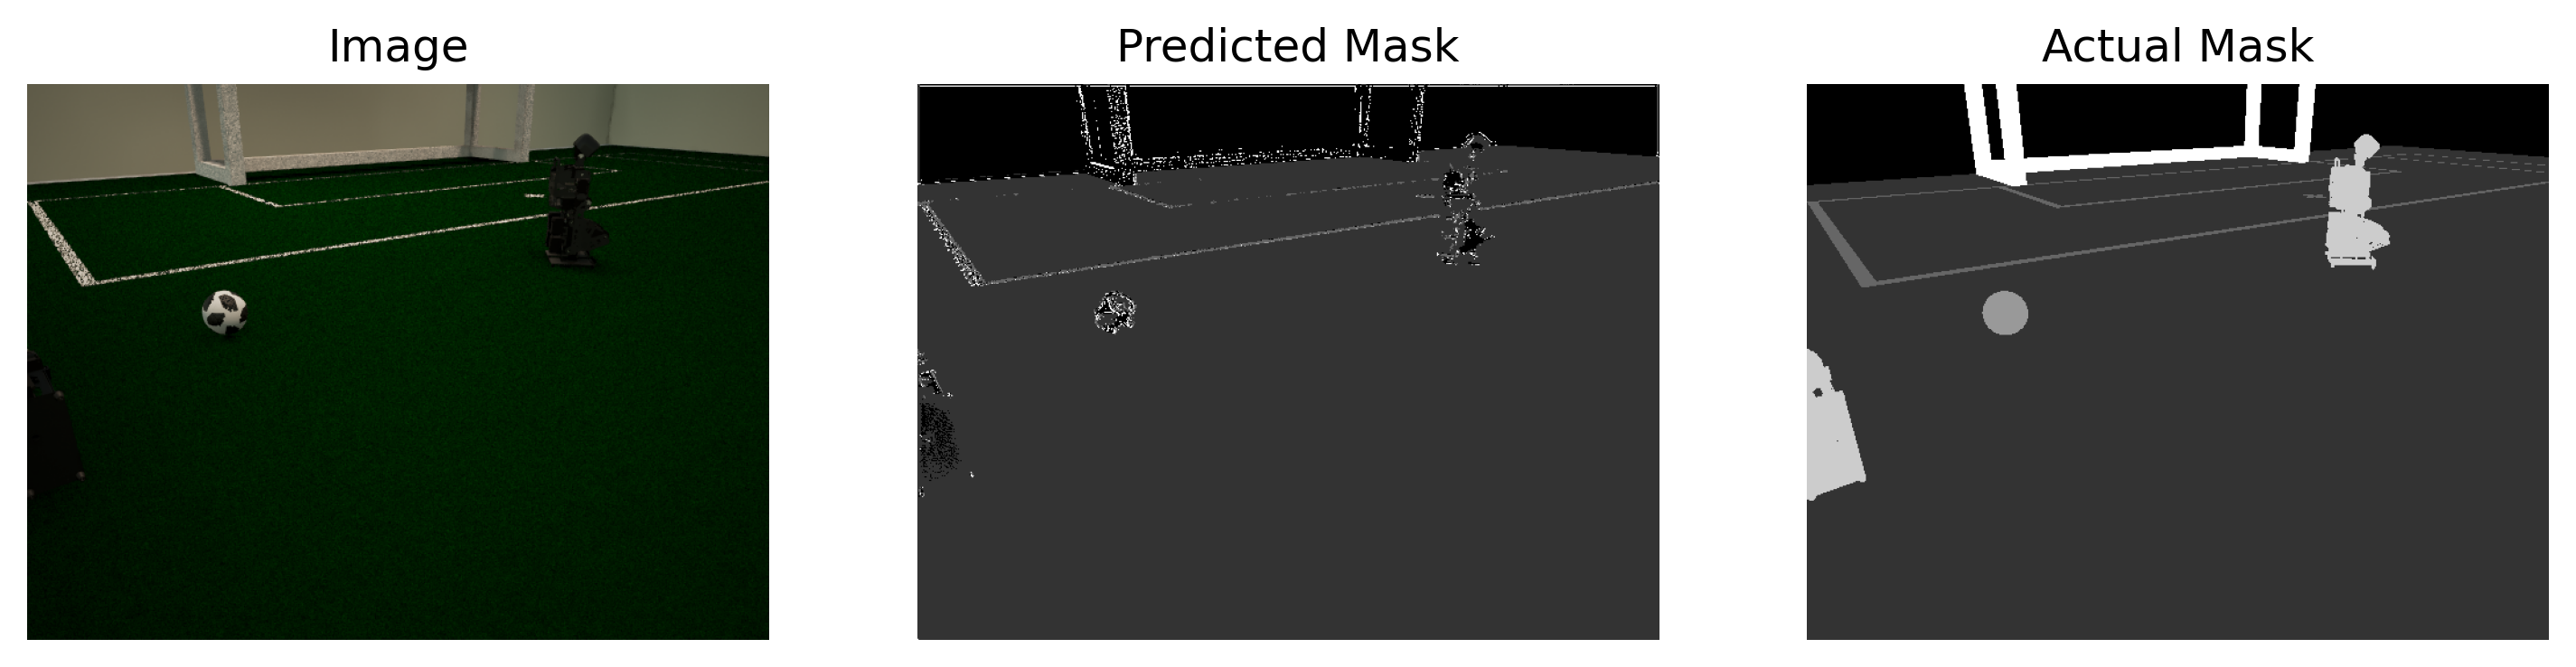

In [10]:
test_preds = model.predict(test_gen)


plt.figure(figsize=(12,18), dpi=300)
for i in range(1):
    img = plt.imread(test_input_paths[i])
    plt.subplot(2, 3, i*3+1)
    plt.imshow(img/img.max())
    plt.axis('off')
    plt.title('Image')
    plt.subplot(2, 3, i*3+2)
    predicted_mask = np.argmax(test_preds[i], axis=-1)
    predicted_mask = np.expand_dims(predicted_mask, axis=-1)
    plt.imshow(predicted_mask/predicted_mask.max(), cmap='gray')
    plt.axis('off')
    plt.title('Predicted Mask')
    plt.subplot(2, 3, i*3+3)
    actual_mask = np.loadtxt(test_target_paths[i])
    plt.imshow(actual_mask/actual_mask.max(), cmap='gray')
    plt.axis('off')
    plt.title('Actual Mask')
plt.show()